In [1]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pymongo
from collections import Counter
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics.pairwise import cosine_similarity

### Dataframe functions

In [27]:
def create_dataframe(recipes, cutoff=int(len(recipes)**(1/3))):
    print('Ingredient cutoff : {} occurrences'.format(cutoff))
    recipe_ids = _get_recipe_ids(recipes)
    common_ingredients = _get_common_ingredients(recipes, cutoff=cutoff)
    df = pd.DataFrame(columns=common_ingredients, index=recipe_ids).fillna(0)
    unknown_servings = []
    for recipe in recipes:
        idx = recipe['id']
        servings = recipe['directions']['servings']
        if not servings:
            unknown_servings.append(recipe)
            #print('Servings missing')
            continue
        for ing, qty in recipe['ingredients'].items(): 
            norm_qty = qty['normalized_qty']
            if ing in df.columns:
                df.loc[idx, ing] = norm_qty / servings
    # Determine approx servings for recipes where it is not specified
    for recipe in unknown_servings:
        servings = _approximate_servings(recipe, df)
        recipe['directions']['approx_servings'] = servings
    # Apply approx servings to recipes and insert data into dataframe
    for recipe in unknown_servings:
        servings = recipe['directions']['approx_servings']
        for ing, qty in recipe['ingredients'].items(): 
            norm_qty = qty['normalized_qty']
            if ing in df.columns:
                df.loc[idx, ing] = norm_qty / servings
    return df

def _get_recipe_ids(recipes):
    recipe_ids = []
    for recipe in recipes:
        recipe_ids.append(recipe['id'])
    return recipe_ids

def _approximate_servings(recipe, df):
    recipe_qtys = []
    df_means = []
    for ing, qty in recipe['ingredients'].items():
        if ing in df.columns:
            recipe_qtys.append(qty['normalized_qty'])
            ing_vals = df[df[ing] != 0][ing]
            df_means.append(np.mean(ing_vals))
    qtys_array = np.array(recipe_qtys)
    df_means_array = np.array(df_means)
    count = 1
    while True:
        err = np.mean(abs(qtys_array/count - df_means_array)) * count
        next_err = np.mean(abs(qtys_array/(count+1) - df_means_array)) * (count+1)
        if next_err > err:
            return count
        count += 1
        err = next_err
        
def _get_common_ingredients(recipes, cutoff=2):
    ingredients = Counter()
    for recipe in recipes:
        for ing in recipe['ingredients'].keys():
            ingredients[ing] += 1
    #print('Number of unique ingredients :', len(ingredients))
    common_ingredients = []
    for item, count in ingredients.most_common():
        if count >= cutoff:
            common_ingredients.append(item)
    #print('Number of common ingredients :', len(common_ingredients))
    return common_ingredients

def get_label_names(recipes, cat_lvl=2):
    labels = []
    key = 'lvl_{}'.format(cat_lvl)
    for recipe in recipes:
        labels.append(recipe['category'][key])
    return labels

def get_label_numbers(label_names, limit=None):
    ordered_names = [key for key, val in Counter(label_names).most_common()]
    label_nums = [ordered_names.index(label) for label in label_names]
    if not limit:
        return ordered_names, label_nums
    else:
        abbr_names = ordered_names[:limit-1] + ['Other']
        abbr_nums = [num if num < limit-1 else limit-1 for num in label_nums]
        return abbr_names, abbr_nums

### Recipe search functions

In [12]:
def find_recipes_matching_search(collection, search_term):
    matching_recipes = []
    for recipe in collection.find():
        if len(recipe['name'].lower().split(search_term.lower())) > 1:
            matching_recipes.append(recipe)
        if not recipe['category']['lvl_2']:
            continue
        elif len(recipe['category']['lvl_2'].lower().split(search_term.lower())) > 1:
            matching_recipes.append(recipe)
        if not recipe['category']['lvl_3']:
            continue
        elif len(recipe['category']['lvl_3'].lower().split(search_term.lower())) > 1:
            matching_recipes.append(recipe)
    return matching_recipes

### Find matching recipes

In [6]:
mc = pymongo.MongoClient()
db = mc['allrecipes']
recipes_coll = db['recipes']

In [16]:
recipes = find_recipes_matching_search(recipes_coll, 'chili')
len(recipes)

705

### Graph results

In [28]:
df = create_dataframe(recipes)
df.shape

Ingredient cutoff : 8 occurrences


(705, 126)

In [75]:
X = df.values
label_names = get_label_names(recipes, cat_lvl=3)
ordered_names, label_nums = get_label_numbers(label_names, limit=4)
cosine_sims = cosine_similarity(X)

Threshold cosine similarity : 0.74


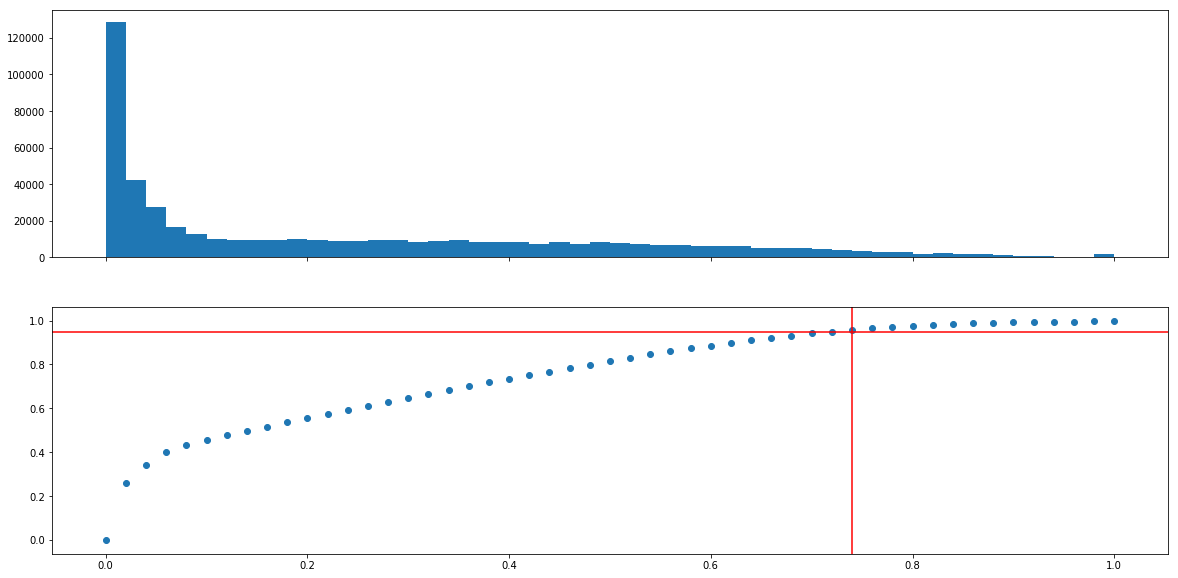

In [71]:
threshold = 0.95
fig, axs = plt.subplots(2,1, figsize=(20,10), sharex=True)
bins = axs[0].hist(cosine_sims.flatten(), bins=50)
cumulative = [np.sum(bins[0][:i])/np.sum(bins[0]) for i in range(len(bins[0])+1)]
axs[1].scatter(bins[1], cumulative)
axs[1].axhline(threshold, c='r')
for i, total in enumerate(cumulative):
    if total > threshold:
        axs[1].axvline(bins[1][i], c='r')
        print('Threshold cosine similarity : {0:0.2f}'.format(bins[1][i]))
        break

In [77]:
G = nx.Graph()
palette = np.array(['#e30057','#00a8e0','#2fb001','k'])
node_colors = []
for i, num in enumerate(label_nums):
    G.add_node(i)
    node_colors.append(palette[num])
edges_to_show = []
for i, row in enumerate(cosine_sims):
    for j in range(i+1, len(cosine_sims)):
        if cosine_sims[i,j] > 0.74:
            G.add_edge(i, j, weight=100*cosine_sims[i,j])
        if cosine_sims[i,j] > 0.74:
            edges_to_show.append((i,j))

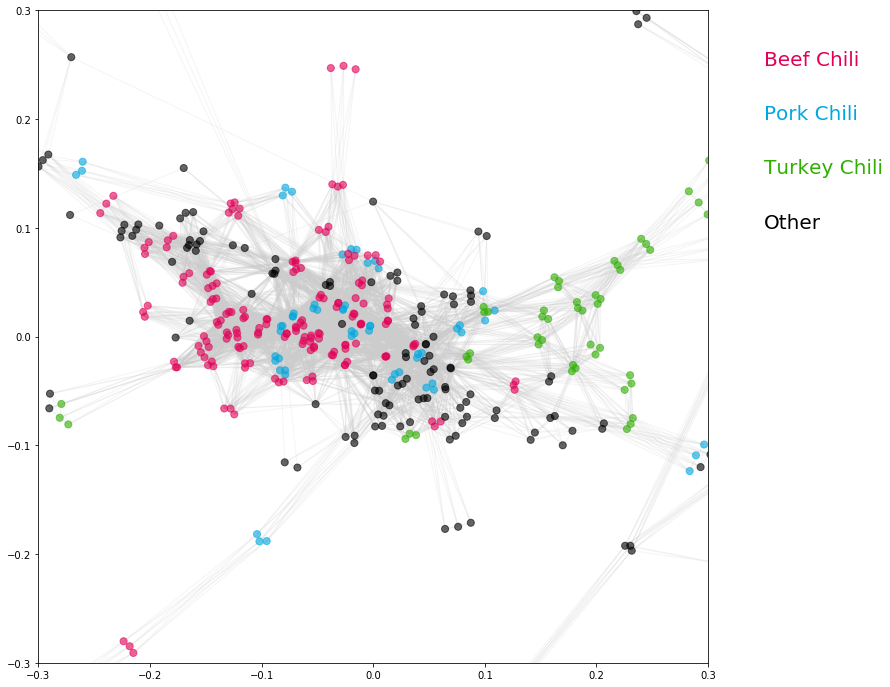

In [80]:
fig, ax = plt.subplots(figsize=(12,12))
spring = nx.spring_layout(G, k=.4, weight='weight')
nx.draw_networkx_nodes(G,
                       pos=spring,
                       node_size=50,
                       node_color=node_colors,
                       ax=ax,
                       alpha=0.6,
                       with_labels=False)
nx.draw_networkx_edges(G,
                       pos=spring,
                       edge_color='#CCCCCC',
                       alpha=0.2,
                       edgelist=edges_to_show)

ax.text(.35, .25, ordered_names[0], color=palette[0], fontsize=20)
ax.text(.35, .2, ordered_names[1], color=palette[1], fontsize=20)
ax.text(.35, .15, ordered_names[2], color=palette[2], fontsize=20)
ax.text(.35, .1, ordered_names[3], color=palette[3], fontsize=20)

#ax.set_facecolor('#CCCCCC')
ax.set_xlim(left=-.3, right=.3)
ax.set_ylim(bottom=-.3, top=.3);

### Cluster into communities

### Find weighted centers of largest/most relevant communities

### Convert cluster centers into recipes

### Approximate confidence in recipes and present to user